<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/master/example01_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－１　正則化付き単回帰モデル

1. サンプルデータの読み込み
1. 線形単回帰の実行
1. 正則化付き基底展開単回帰の実行



In [1]:
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定


## Google Colaboratory でファイルを読み込む

以下の方法があります。

1. ファイルをアップロードする
1. URL を指定する

In [2]:
# ファイルをアップロードする
from google.colab import files
uploaded_file = files.upload()
filename = next(iter(uploaded_file))
print(filename)

# URLを指定する
#filename = 'https://raw.githubusercontent.com/msiplab/EicEngLabIV/master/data/sample01_01.txt'

#観測データのファイル
#filename = './data/practice01_03.txt'
#filename = './data/practice01_04.txt'

Saving practice01_03.txt to practice01_03 (2).txt
practice01_03.txt


In [3]:
#観測データ（空白区切り）の読み込み
dataset = pd.read_csv(filename, delim_whitespace=True)
#dataset = pd.read_csv(filename)
display(dataset)

#観測データ数
nSamples = len(dataset)


,NANOMETERS,REFLECTANCE
0,2000.0,5.350
1,1998.0,7.668
2,1996.0,10.086
3,1994.0,8.559
4,1992.0,5.733
...,...,...
886,228.0,10.305
887,226.0,10.528
888,224.0,9.885
889,222.0,9.089


In [4]:
# 説明変数の設定
x = dataset.iloc[:,0].values.reshape(-1,1) 
#display(x)

# 目的変数の設定
y = dataset.iloc[:,1].values.reshape(-1,1)
#display(y)

## 観測データの散布図

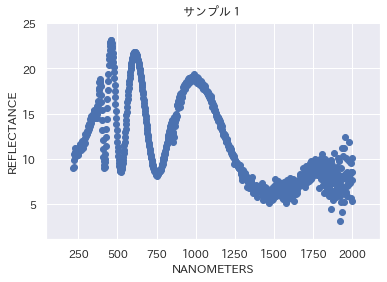

In [5]:
# 散布図の範囲情報の抽出
minx = np.min(x)
maxx = np.max(x)
rx = maxx-minx
cx = 0.5*rx
miny = np.min(y)
maxy = np.max(y)
ry = maxy-miny
cy = 0.5*ry

# 散布図の表示
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_title("サンプル１")
ax.set_xlabel(dataset.columns[0])
ax.set_ylabel(dataset.columns[1])
ax.set_xlim([minx-0.1*rx,maxx+0.1*rx])
ax.set_ylim([miny-0.1*ry,maxy+0.1*ry])
ax.grid(True)
plt.show()




## 線形単回帰の実行

In [6]:
from sklearn.linear_model import LinearRegression

# 線形単回帰のインスタンス生成
regu = LinearRegression()

# 線形単回帰分析
regu.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

β0 = 17.85 
β1 = -0.01 


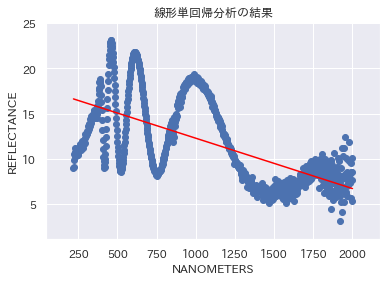

In [7]:
# 推定結果
beta0 = regu.intercept_[0]
beta1 = regu.coef_[0][0]
print("β0 = {0:5.2f} ".format(beta0))
print("β1 = {0:5.2f} ".format(beta1))

# 回帰直線をプロット
fig, ax = plt.subplots()
xfit = np.linspace(minx,maxx,nSamples).reshape(-1,1) # 列ベクトル化
yfit = regu.predict(xfit)
ax.scatter(x,y)
ax.plot(xfit,yfit, color = 'red')
ax.set_title("線形単回帰分析の結果")
ax.set_xlabel(dataset.columns[0])
ax.set_ylabel(dataset.columns[1])
ax.set_xlim([minx-0.1*rx,maxx+0.1*rx])
ax.set_ylim([miny-0.1*ry,maxy+0.1*ry])
ax.grid(True)
plt.show()

## 基底展開単回帰モデルのパラメータの選択

- RBF単回帰（K平均法を利用した2段階推定クラスを定義）
- 交差検証正則化モデル（sklearn.linear_model.LassoCV/RigdeCV）を利用

In [8]:
"""GaussianFeaturesWithKmenasモジュール

    Copyright (c) 2020, Shogo MURAMATSU, All rights reserved.
"""
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeaturesWithKmeans(BaseEstimator, TransformerMixin):
    """K平均法を利用した2段階推定法によるガウス基底関数

        scikit-learn LinearRegression推定器に渡すためのガウス基底関数による
        特徴量への変換クラス    

    Attirbutes:
        nbfs (int): 基底関数の数
        centers_ (numpy.ndarray): 各ガウス関数の中心
        widths_ (numpy.ndarray): 各ガウス関数の幅

    References:

        * 小西貞則「多変量解析入門－線形から非線形へ－」岩波書店
        * Jake VanderPlas（菊池彰訳）「Pythonデータサイエンスハンドブック」オライリージャパン
    """
    def __init__(self, nbfs, width_factor=1.0, prekmeans=True):
        """GaussianFeaturesWithKMeansのコンストラクタ"""
        self.nbfs = nbfs
        self.width_factor = width_factor
        self.prekmeans = prekmeans

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / (width + 1e-300)
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        ndims = X.shape[1]
        if self.prekmeans: # K平均法を前処理に利用
            # 説明変数の標準化とK平均法の実行
            scaler = StandardScaler()         
            kmeans = KMeans(n_clusters=self.nbfs,random_state=0)
            X = scaler.fit_transform(X) 
            kmeans.fit(X) 
            # クラスタラベルの抽出
            labels = kmeans.predict(X).reshape(-1,1)            
            # 各クラスタの中心と幅を抽出
            clusters = pd.DataFrame(np.concatenate((labels,X),axis=1)).groupby([0])
            centers = scaler.inverse_transform(kmeans.cluster_centers_) 
            widths = (self.width_factor * scaler.scale_ * clusters.std(ddof=0)).to_numpy()
            #プライベート静的メソッド_gauss_basisでブロードキャスト計算するために成形
            if ndims == 1:
                self.centers_ = centers.reshape(-1,)
                self.widths_ = widths.reshape(-1,)
            else:
                self.centers_ = centers.reshape(-1,ndims,1).transpose(2,1,0) 
                self.widths_ = widths.reshape(-1,ndims,1).transpose(2,1,0)
        else: # 等間隔にガウス基底を配置（単変量のみ）
            if ndims == 1:
                centers = np.linspace(X.min(), X.max(), self.nbfs) 
                self.centers_ = centers
                self.widths_ = self.width_factor * (centers[1] - centers[0]) * np.ones(self.nbfs)
            else:
                raise Exception('prekmeansを True に設定してください．重回帰はK平均法による事前推定のみ対応しています．') 
        
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:,:, np.newaxis], self.centers_,
                                self.widths_, axis=1)

### 正則化付き単回帰モデルの評価
- リッジ交差検証(CV)モデル
- ラッソ交差検証(CV)モデル

In [9]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# ラッソ回帰の選択
isLasso = True # False の場合はリッジ回帰を選択

# RFB重回帰の選択
isRBF = True # False の場合は多項式重回帰を選択
width_factor = 2.0 # ガウス関数の広さ

# 評価する基底数の最大値（回帰分析が不安定になるときは値を減らして試す）
maxdeg = 80 

# 正則化法の選択
if isLasso: # ラッソ正則化交差検証(CV)モデル
    reg = LassoCV()
else: # リッジ正則化交差検証(CV)モデル
    reg = RidgeCV()

# 基底展開法の特徴量を選択
if isRBF: # RBF単回帰モデル
    phi = GaussianFeaturesWithKmeans(nbfs=maxdeg,width_factor=width_factor)
else: # 多項式単回帰モデル
    phi = PolynomialFeatures(degree=maxdeg,include_bias=False)
        
# 基底展開単回帰モデルのインスタンス生成
regm = make_pipeline(phi,reg)
# 基底展開単回帰分析
regm.fit(x,y)

Pipeline(memory=None,
         steps=[('gaussianfeatureswithkmeans',
                 GaussianFeaturesWithKmeans(nbfs=80, prekmeans=True,
                                            width_factor=2.0)),
                ('lassocv',
                 LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001,
                         fit_intercept=True, max_iter=1000, n_alphas=100,
                         n_jobs=None, normalize=False, positive=False,
                         precompute='auto', random_state=None,
                         selection='cyclic', tol=0.0001, verbose=False))],
         verbose=False)

In [10]:
# 最適パラメータの推定結果
alpha = regm[1].alpha_
print("λ = {0:5.2e} ".format(alpha))
w0 = regm[1].intercept_
if not isLasso:
    w0 = w0[0]
print("w0 = {0:5.2f} ".format(w0))
for idx in range(0,maxdeg):
    if isLasso:
        w = regm[1].coef_[idx]
    else:
        w = regm[1].coef_[0][idx]
    print("w{0:d} = {1:5.2f} ".format(idx+1,w))


λ = 2.75e-04 
w0 =  9.35 
w1 = -1.81 
w2 =  1.56 
w3 = -0.35 
w4 =  5.30 
w5 = -1.96 
w6 =  0.00 
w7 =  6.47 
w8 = -1.55 
w9 = -0.64 
w10 =  1.93 
w11 =  9.65 
w12 =  2.65 
w13 = -0.78 
w14 = -1.84 
w15 = -0.92 
w16 = -1.52 
w17 =  4.00 
w18 = -0.78 
w19 =  1.23 
w20 =  4.94 
w21 =  6.09 
w22 = -2.41 
w23 =  6.45 
w24 =  0.12 
w25 = -0.87 
w26 = -2.01 
w27 =  1.18 
w28 =  5.21 
w29 =  7.18 
w30 =  4.20 
w31 =  7.66 
w32 = -1.02 
w33 =  2.55 
w34 = -2.10 
w35 =  5.37 
w36 =  2.82 
w37 = -1.11 
w38 =  6.37 
w39 = -0.96 
w40 = -1.11 
w41 =  0.63 
w42 = -2.35 
w43 = 13.76 
w44 = -0.51 
w45 = -0.97 
w46 =  5.77 
w47 = -0.15 
w48 =  8.01 
w49 = -0.41 
w50 = -1.17 
w51 = -2.54 
w52 = -1.48 
w53 =  5.77 
w54 = -1.09 
w55 =  0.00 
w56 =  0.90 
w57 =  1.31 
w58 =  0.56 
w59 =  0.00 
w60 =  0.18 
w61 =  4.24 
w62 =  5.01 
w63 =  2.44 
w64 = -1.15 
w65 =  4.11 
w66 =  2.79 
w67 =  2.01 
w68 =  3.57 
w69 =  3.51 
w70 =  4.30 
w71 = -1.68 
w72 = -1.92 
w73 = -0.98 
w74 = -0.53 
w75 = -2.37 
w76 = -0

### 散布図と曲線の表示

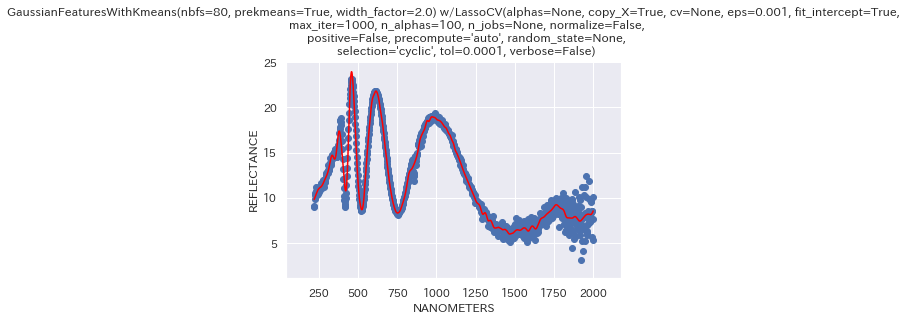

In [11]:
# 回帰曲線をプロット
fig, ax = plt.subplots()
yfit = regm.predict(xfit)
ax.scatter(x,y)
ax.plot(xfit,yfit, color = 'red')
ax.set_title("{0} w/{1}".format(regm[0],regm[1]))
ax.set_xlabel(dataset.columns[0])
ax.set_ylabel(dataset.columns[1])
ax.set_xlim([minx-0.1*rx,maxx+0.1*rx])
ax.set_ylim([miny-0.1*ry,maxy+0.1*ry])
ax.grid(True)
plt.show()